In [47]:
%matplotlib inline
from imports import *
font = {'family' : 'Times New Roman',
        'weight' : 'bold',
        'size'   : 16}
plt.rc('font', **font)
order = ['node','Python','Ruby']
d = {'python':'Python','ruby':'Ruby'}
import effect_size
from tqdm.notebook import tqdm
from datetime import datetime
plt.rcParams['text.usetex'] = True

# LOAD DATA

In [48]:
diffs = pd.read_csv('../data/diff_metrics.csv.gz')
diffs.head(2)

,id,v1,v2,BlockAddition,BlockEdit,BlockRelocation,BlockRemoval,RoleVariableAddition,RoleVariableEdit,RoleVariableRelocation,...,MetaEdit,PlatformAddition,PlatformRemoval,TaskAddition,TaskEdit,TaskRelocation,TaskRemoval,TaskFileAddition,TaskFileRelocation,TaskFileRemoval
0,030.ansible_bfg,1.0.0,1.0.1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
1,030.ansible_eksctl,1.0.0,1.0.1,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [49]:
diffs.id.unique().size

8861

In [50]:
diffs.DependencyAddition.sum()

1272

# Preparation

In [51]:
diffs['v1'] = diffs['v1'].apply(lambda d: d.replace('v',''))
diffs['v2'] = diffs['v2'].apply(lambda d: d.replace('v',''))

In [53]:
len(diffs)

89568

In [54]:
RE_SEMVER = r'^(?:v|V)?(?P<v_major>\d+)\.(?P<v_minor>\d+)\.(?P<v_patch>\d+)(?P<v_misc>.*)$'
def comply_semver(series_of_releases):
    extracted = series_of_releases.str.extract(RE_SEMVER, expand=True)
    return (
        extracted
        [['v_major', 'v_minor', 'v_patch']]
        .astype('str')
        .assign(Semver=lambda d: d['v_major'] + '.' + d['v_minor'] + '.' + d['v_patch'])
        ['Semver']
    )

In [55]:
diffs['fromm'] = comply_semver(diffs['v1'])
diffs['tot'] = comply_semver(diffs['v2'])

In [56]:
def type_release(v2,fromm,tot):

    if v2 == "HEAD":
        return 'head'
    fromm=fromm.split('.')
    tot=tot.split('.')
    
    if fromm[-1] == 'nan' or tot[-1] == "nan":
        return 'notSemver'
    if fromm[0]!=tot[0]:
        return 'major'
    if fromm[1]!=tot[1]:
        return 'minor'
    if fromm[2]!=tot[2]:
        return 'patch'
    return 'pre'

diffs['release'] = diffs.apply(lambda d: type_release(d['v2'], d['fromm'], d['tot']), axis=1)

In [57]:
diffs.release.unique()

array(['patch', 'minor', 'major', 'pre'], dtype=object)

In [58]:
diffs = diffs.query('release != "notSemver" and release != "pre"')
diffs.fromm = diffs.fromm.replace({'nan.nan.nan':'first commit'})

In [59]:
df_melted = (pd.melt(diffs.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )

## Let's check the number of changes that happend for each release type

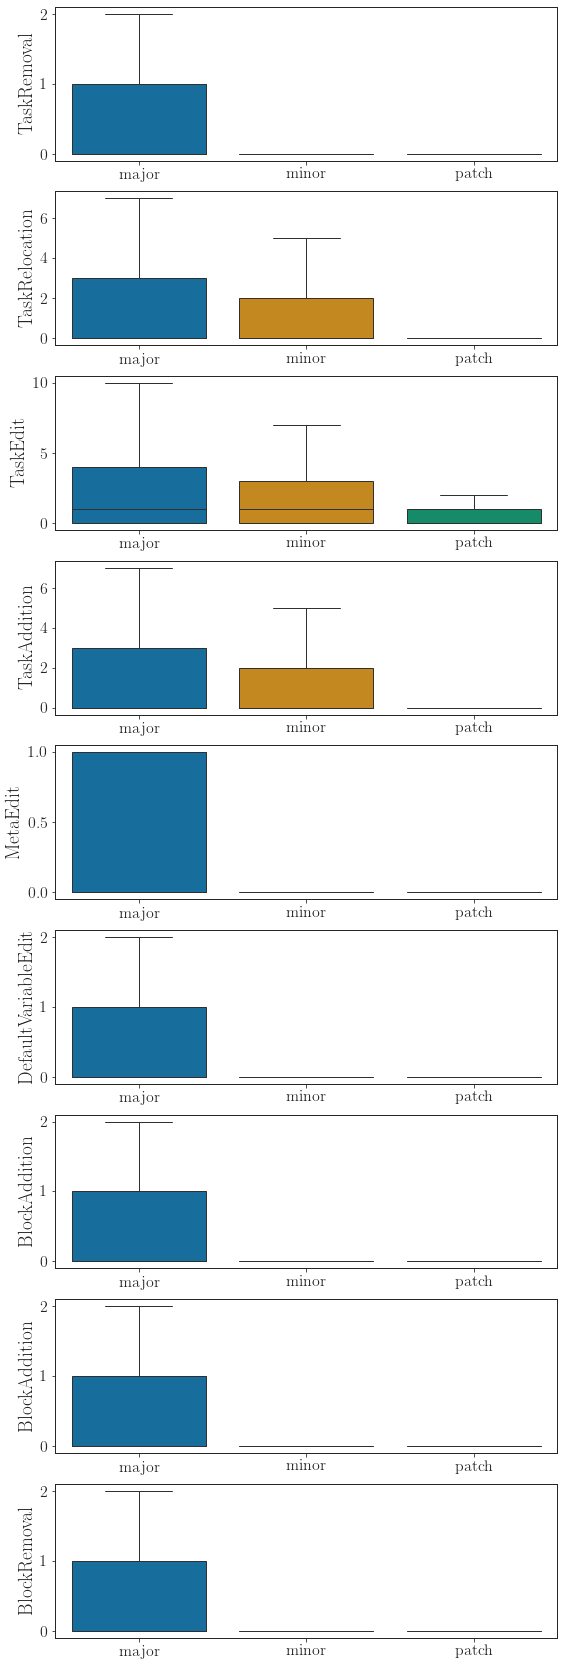

In [61]:
cols= diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
cols = ['TaskRemoval','TaskRelocation','TaskEdit','TaskAddition','MetaEdit','DefaultVariableEdit','BlockAddition','BlockAddition', 'BlockRemoval']
fig, axes = plt.subplots(len(cols), 1, sharex=False, sharey=False)
fig.set_size_inches(9,30)

for i, var in enumerate(cols):
    df_tmp = df_melted.query('variable =="'+var+'"')
    ax = sns.boxplot(x="release", 
                     y="value", 
                     order = ['major','minor','patch'],
                     data=df_tmp, 
                     ax=axes[i],
                     showfliers=False,
                     linewidth=1)
    ax.set_ylabel(var)
    ax.set_xlabel('')

(0.0, 10.0)

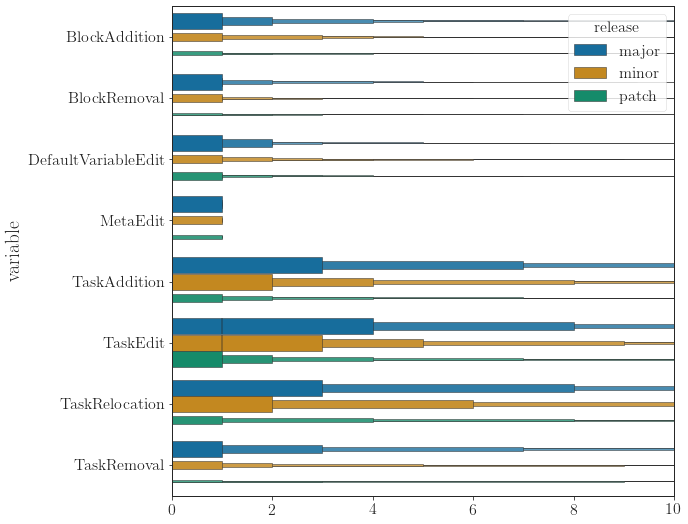

In [62]:
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
fig.set_size_inches(9,9)
cols = ['TaskRemoval','TaskRelocation','TaskEdit','TaskAddition','MetaEdit','DefaultVariableEdit','BlockAddition','BlockAddition', 'BlockRemoval']

df_melted2 = df_melted[df_melted.variable.isin(cols)]
ax = sns.boxenplot(x="value", 
                 y="variable", 
                 hue='release',
                 hue_order = ['major','minor','patch'],
                 data=df_melted2, 
                 linewidth=1)
ax.set_xlabel('')
ax.set_xlim(0,10)


In [63]:
diffs.columns

Index(['id', 'v1', 'v2', 'BlockAddition', 'BlockEdit', 'BlockRelocation',
       'BlockRemoval', 'RoleVariableAddition', 'RoleVariableEdit',
       'RoleVariableRelocation', 'RoleVariableRemoval', 'RoleVarFileAddition',
       'RoleVarFileRelocation', 'RoleVarFileRemoval',
       'DefaultVariableAddition', 'DefaultVariableEdit',
       'DefaultVariableRelocation', 'DefaultVariableRemoval',
       'DefaultVarFileAddition', 'DefaultVarFileRelocation',
       'DefaultVarFileRemoval', 'DependencyAddition', 'DependencyRemoval',
       'HandlerBlockAddition', 'HandlerBlockEdit', 'HandlerBlockRelocation',
       'HandlerBlockRemoval', 'HandlerTaskAddition', 'HandlerTaskEdit',
       'HandlerTaskRelocation', 'HandlerTaskRemoval', 'HandlerFileAddition',
       'HandlerFileRelocation', 'HandlerFileRemoval', 'MetaEdit',
       'PlatformAddition', 'PlatformRemoval', 'TaskAddition', 'TaskEdit',
       'TaskRelocation', 'TaskRemoval', 'TaskFileAddition',
       'TaskFileRelocation', 'TaskFileRemoval

## let's group variables 

In [64]:
diffs['Block'] = diffs['BlockAddition'] + diffs['BlockEdit']+ diffs['BlockRelocation'] + diffs['BlockRemoval']
diffs['RoleVariable'] = diffs['RoleVariableAddition'] + diffs['RoleVariableEdit']+ diffs['RoleVariableRelocation']+ diffs['RoleVariableRemoval']
diffs['RoleVariableFile'] = diffs['RoleVarFileAddition'] + diffs['RoleVarFileRelocation']+ diffs['RoleVarFileRemoval']
diffs['DefaultVariable'] = diffs['DefaultVariableAddition'] + diffs['DefaultVariableEdit']+ diffs['DefaultVariableRelocation'] + diffs['DefaultVariableRemoval']
diffs['DefaultVariableFile'] = diffs['DefaultVarFileAddition'] + diffs['DefaultVarFileRelocation']+ diffs['DefaultVarFileRemoval'] 
diffs['Dependency'] = diffs['DependencyAddition'] + diffs['DependencyRemoval']
diffs['HandlerBlock'] = diffs['HandlerBlockAddition'] + diffs['HandlerBlockEdit']+ diffs['HandlerBlockRelocation'] + diffs['HandlerBlockRemoval']
diffs['HandlerTask'] = diffs['HandlerTaskAddition'] + diffs['HandlerTaskEdit']+ diffs['HandlerTaskRelocation']  + diffs['HandlerTaskRemoval']
diffs['HandlerFile'] = diffs['HandlerFileAddition'] + diffs['HandlerFileRelocation']+ + diffs['HandlerFileRemoval']
diffs['Task'] = diffs['TaskEdit']+ diffs['TaskAddition'] +  diffs['TaskRelocation'] + diffs['TaskRemoval']
diffs['TaskFile'] = diffs['TaskFileAddition'] + diffs['TaskFileRelocation']+ diffs['TaskFileRemoval']
diffs['Platform'] = diffs['PlatformAddition'] + diffs['PlatformRemoval']

cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']

In [65]:
df_melted = (pd.melt(diffs.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )

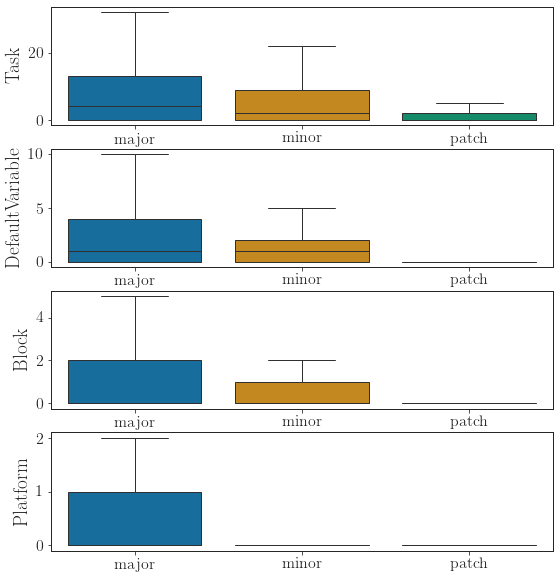

In [66]:
cols = ['Task','DefaultVariable','Block','Platform']
fig, axes = plt.subplots(len(cols), 1, sharex=False, sharey=False)
fig.set_size_inches(9,10)

for i, var in enumerate(cols):
    df_tmp = df_melted.query('variable =="'+var+'"')
    ax = sns.boxplot(x="release", 
                     y="value", 
                     order = ['major','minor','patch'],
                     data=df_tmp, 
                     ax=axes[i],
                     #color='blue',
                     showfliers=False,
                     linewidth=1)
    #ax.figure.set_size_inches(9,3)
    ax.set_ylabel(var)
    ax.set_xlabel('')
    #ax.set_xlabel('proportion of releases')
    #ax.set_xlim(0,40)


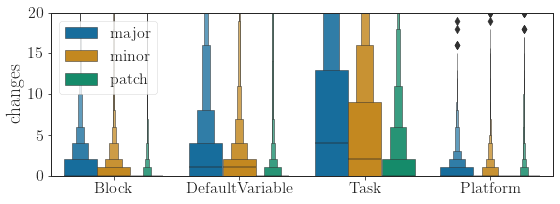

In [67]:
# Distribution of number of changes for each variable
fig, axes = plt.subplots(1, 1, sharex=False, sharey=False)
fig.set_size_inches(9,3)
cols = ['Task','DefaultVariable','Block','Platform']

df_melted2 = df_melted[df_melted.variable.isin(cols)]
ax = sns.boxenplot(x="variable", 
                 y="value", 
                 hue='release',
                 hue_order = ['major','minor','patch'],
                 data=df_melted2, 
                #ax=axes[i],
                 #color='blue',
                 #showfliers=False,
                 linewidth=1)
#ax.figure.set_size_inches(9,3)
ax.set_ylabel('changes')
ax.set_xlabel('')
ax.set_ylim(0,20)
ax.legend(loc='upper left')


In [68]:
prop = diffs[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]

In [69]:
diffs.release.unique()

array(['patch', 'minor', 'major'], dtype=object)

## Let's check how many versions changes specific variables

In [70]:
cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']
tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
print(tab.sort_values('major', ascending=False)[['patch','minor','major']].to_latex())

\begin{tabular}{lrrr}
\toprule
release &  patch &  minor &  major \\
\midrule
Task                &  38.87 &  65.90 &  70.58 \\
DefaultVariable     &  23.88 &  51.19 &  60.50 \\
Block               &   8.29 &  26.79 &  36.56 \\
MetaEdit            &  11.10 &  19.93 &  35.53 \\
Platform            &   8.02 &  15.61 &  25.10 \\
RoleVariable        &  10.25 &  21.15 &  24.78 \\
TaskFile            &   4.58 &  17.14 &  22.96 \\
HandlerTask         &   3.21 &   9.47 &  13.65 \\
RoleVariableFile    &   3.74 &   9.35 &  11.01 \\
Dependency          &   1.15 &   2.75 &   6.63 \\
HandlerBlock        &   1.04 &   3.57 &   5.69 \\
HandlerFile         &   0.51 &   1.88 &   3.80 \\
DefaultVariableFile &   0.99 &   1.55 &   1.87 \\
\bottomrule
\end{tabular}



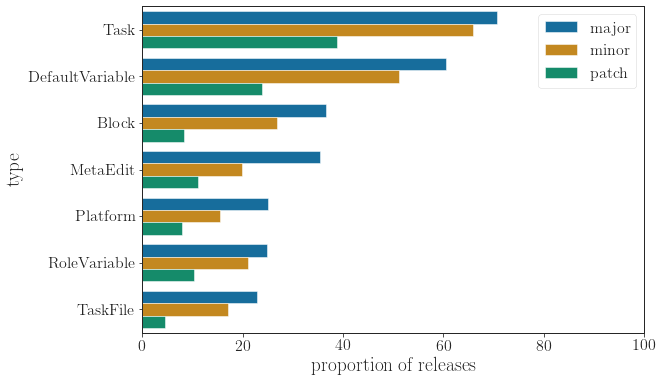

In [71]:
df_melted = pd.melt(tab.reset_index(), 
             id_vars=['index'],
             value_vars=['major','minor','patch']
            ).rename(columns={'index':'type'})
ax = sns.barplot(y="type", 
                 x="value", 
                 hue = 'release',
                 data=df_melted, 
                 hue_order = ['major','minor','patch'],
                 order = tab.sort_values('major', ascending=False).head(7).reset_index()['index'].tolist()
                 #color='blue'
                )
ax.figure.set_size_inches(9,6)
#ax.set_xlabel("")
ax.set_xlabel('proportion of releases')
ax.set_xlim(0,100)
ax.legend(loc='upper right') #handles=legend_elements, 

In [72]:
# Considering all releases
prop = len(diffs[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop
    print(x, round(df_tmp, 2))

Block 13.66
RoleVariable 13.31
RoleVariableFile 5.31
DefaultVariable 31.57
DefaultVariableFile 1.16
Dependency 1.77
HandlerBlock 1.81
HandlerTask 5.07
HandlerFile 0.97
Task 46.26
TaskFile 8.19
Platform 10.49
MetaEdit 14.19


In [73]:
diffs_folders= diffs.copy()
diffs_folders['tasks'] = diffs_folders['Task'] + diffs_folders['Block'] + diffs_folders['TaskFile']
diffs_folders['defaults'] = diffs_folders['DefaultVariable'] + diffs_folders['DefaultVariableFile'] 
diffs_folders['meta'] = diffs_folders['MetaEdit'] + diffs_folders['Platform'] + diffs_folders['Dependency']
diffs_folders['vars'] = diffs_folders['RoleVariable'] + diffs_folders['RoleVariableFile'] 
diffs_folders['handlers'] = diffs_folders['HandlerTask'] + diffs_folders['HandlerBlock'] + diffs_folders['HandlerFile']
df_melted_2 = (pd.melt(diffs_folders.drop(['fromm','tot'], axis=1),
                     id_vars=['id','v1','v2','release'],
                     value_vars=diffs.drop(['id','v1','v2','fromm','tot','release'], axis=1).columns.tolist()
                    )
            )
prop_2 = diffs_folders[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]

cols = ['tasks','defaults','meta','vars','handlers']

tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs_folders.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop_2
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
print(tab.sort_values('major', ascending=False)[['patch','minor','major']].to_latex())

\begin{tabular}{lrrr}
\toprule
release &  patch &  minor &  major \\
\midrule
tasks    &  39.03 &  65.98 &  70.72 \\
defaults &  23.95 &  51.26 &  60.55 \\
meta     &  16.96 &  29.45 &  47.15 \\
vars     &  10.78 &  21.81 &  25.59 \\
handlers &   3.37 &   9.81 &  14.82 \\
\bottomrule
\end{tabular}



In [74]:
prop_2 = len(diffs_folders[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs_folders.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop_2
    print(x, round(df_tmp, 2))

tasks 46.4
defaults 31.64
meta 21.13
vars 13.89
handlers 5.32


In [41]:
prop = diffs[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
cols = ['DefaultVariableAddition','DefaultVariableEdit','DefaultVariableRelocation','DefaultVariableRemoval', 
 'TaskAddition','TaskEdit','TaskRelocation','TaskRemoval']
tab =[]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
tab

release,major,minor,patch
DefaultVariableAddition,39.97,37.05,11.94
DefaultVariableEdit,31.29,22.21,13.21
DefaultVariableRelocation,0.07,0.03,0.06
DefaultVariableRemoval,28.56,9.47,3.25
TaskAddition,42.53,39.92,14.24
TaskEdit,59.31,52.63,31.88
TaskRelocation,39.71,33.82,12.84
TaskRemoval,28.93,15.29,5.68


In [383]:
prop = len(diffs[['id','v1','v2','release']].drop_duplicates())
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = len(diffs.query(x+'>0')[['id','v1','v2','release']].drop_duplicates())
    df_tmp = df_tmp*100/prop
    print(x, round(df_tmp, 2))

DefaultVariableAddition 18.74
DefaultVariableEdit 16.03
DefaultVariableRelocation 0.05
DefaultVariableRemoval 5.82
TaskAddition 21.17
TaskEdit 37.71
TaskRelocation 18.69
TaskRemoval 8.89


In [ ]:
print('Analysis for zero release')
diffs_zero = diffs.copy()
diffs_zero['zero'] =diffs_zero['v2'].apply(lambda x: x.startswith('0.'))
diffs_zero = diffs_zero.query('zero == True')
cols = ['Block','RoleVariable','RoleVariableFile','DefaultVariable','DefaultVariableFile','Dependency',
        'HandlerBlock','HandlerTask','HandlerFile','Task','TaskFile','Platform','MetaEdit']
tab =[]
prop = diffs_zero[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
for x in cols: #['Task','DefaultVariable','Block']:
    df_tmp = diffs_zero.query(x+'>0')[['id','v1','v2','release']].drop_duplicates().groupby('release').count()[['id']]
    df_tmp = df_tmp*100/prop
    df_tmp = df_tmp.rename(columns={'id':x})
    df_tmp[x] = df_tmp[x].apply(lambda x: round(x,2))
    df_tmp = df_tmp.T
    tab.append(df_tmp)
tab = pd.concat(tab)
tab.sort_values('minor', ascending=False)

In [384]:
def sum_row(d, cols):
    s = 0
    for c in cols:
        s = s + d[c]
    return s

In [385]:
cols = diffs.drop(['id','v1','v2', 'tot','fromm','release'], axis=1).columns.tolist()

diffs['total'] = diffs.fillna(0).apply(lambda d: sum_row(d, cols), axis=1)

In [386]:
diffs['total2'] = diffs['total'].apply(lambda d: d>0)


In [387]:
# Releases that did not touch anything
len(diffs.query('total==0'))*100/prop, len(diffs.query('total>0'))*100/prop

(31.49326473972788, 68.50673526027212)